In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load train and validation datasets
train_data = pd.read_csv("./datasets/mod_04_hw_train_data.csv")
valiid_data = pd.read_csv("./datasets/mod_04_hw_valid_data.csv")

In [3]:
# observe data
train_data.head()


,Name,Phone_Number,Experience,Qualification,University,Role,Cert,Date_Of_Birth,Salary
0,Jennifer Hernandez,120-602-1220,3.0,Msc,Tier2,Mid,Yes,25/08/1972,98000
1,Timothy Walker,840-675-8650,5.0,PhD,Tier2,Senior,Yes,03/12/2013,135500
2,David Duran,556-293-8643,5.0,Msc,Tier2,Senior,Yes,19/07/2002,123500
3,Gloria Ortega,463-559-7474,3.0,Bsc,Tier3,Mid,No,19/02/1970,85000
4,Matthew Steele,968-091-7683,5.0,Bsc,Tier2,Senior,Yes,20/02/1970,111500


In [4]:
# observe data types and missed data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           249 non-null    object 
 1   Phone_Number   249 non-null    object 
 2   Experience     247 non-null    float64
 3   Qualification  248 non-null    object 
 4   University     249 non-null    object 
 5   Role           246 non-null    object 
 6   Cert           247 non-null    object 
 7   Date_Of_Birth  249 non-null    object 
 8   Salary         249 non-null    int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 17.6+ KB


In [5]:

# get dataset statistics
train_data.describe()


,Experience,Salary
count,247.000000,249.000000
mean,3.441296,98186.746988
std,1.496471,23502.622217
min,1.000000,49500.000000
25%,2.000000,78500.000000
50%,4.000000,104500.000000
75%,5.000000,116500.000000
max,5.000000,141500.000000


In [6]:
# primary feature investigation
# we can observe that 'Name', 'Phone_Number', 'Date_Of_Birth' are not useful features for salary prediction
# let's leave only important features
imp_features = ["Experience", "Qualification", "University", "Role", "Cert"]
X_train_imp = train_data[imp_features]
y_train = train_data["Salary"]

X_valid_imp = valiid_data[imp_features]
y_valid = valiid_data["Salary"]


In [7]:
X_train_cat = X_train_imp.select_dtypes(include="object")
X_train_num = X_train_imp.select_dtypes(include="number")


# fill missed values
imputer_num = SimpleImputer().set_output(transform="pandas")
X_train_num = imputer_num.fit_transform(X_train_num)
X_valid_num = imputer_num.transform(X_valid_imp.select_dtypes(include="number"))

imputer_cat = SimpleImputer(strategy="most_frequent").set_output(transform="pandas")
X_train_cat = imputer_cat.fit_transform(X_train_cat)
X_valid_cat = imputer_cat.transform(X_valid_imp.select_dtypes(include="object"))

In [8]:
# encode categorical features
encoder = ce.TargetEncoder()

X_train_cat = encoder.fit_transform(X_train_cat, y_train)
X_valid_cat = encoder.transform(X_valid_cat)

In [9]:
# combine numerical and categorical features
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_valid = pd.concat([X_valid_num, X_valid_cat], axis=1)

In [10]:
# features normalization
scaler = StandardScaler().set_output(transform="pandas")

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [11]:
# build KNeighborsRegressor model
model = KNeighborsRegressor().fit(X_train, y_train)

y_prd = model.predict(X_valid)

mape = mean_absolute_percentage_error(y_valid, y_prd)

print(f"Validation MAPE: {mape:.2%}") # 10.47%
# we obtained MAPE of 10.47%, lets try to improve it

Validation MAPE: 10.47%


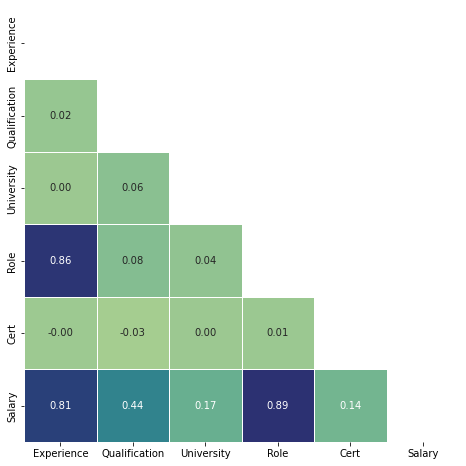

In [12]:
# build correlation matrix
corr_mtx = pd.concat([X_train, y_train], axis=1).corr()

fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(
    corr_mtx,
    cmap="crest",
    annot=True,
    fmt=".2f",
    linewidth=0.5,
    mask=np.triu(np.ones_like(corr_mtx, dtype=bool)),
    square=True,
    cbar=False,
    ax=ax,
)

plt.show()
# we see that 'Role' and 'Experience' have strong positive correlation between each other, but they have high correlation with the target value too. So, these features are important and couldn't be deleted from our model

In [13]:
# after manual investigation we notice that "Qualification" is not important for our model and without it we could improve our model a lot
# let's delete "Qualification" feature from our model
X_train = X_train.drop(columns=["Qualification"])
X_valid = X_valid.drop(columns=["Qualification"])

In [14]:
# build KNeighborsRegressor model without "Qualification"
model_upd = KNeighborsRegressor().fit(X_train, y_train)

y_prd_upd = model_upd.predict(X_valid)

mape_upd = mean_absolute_percentage_error(y_valid, y_prd_upd)

print(f"Validation MAPE for updated model: {mape_upd:.2%}") # 5.36%
# we obtained MAPE of 5.36%, that is great, but lets try to improve it

Validation MAPE for updated model: 5.36%


In [15]:
# try to find the best parameters for our model with GridSearchCV
parameters = {
    "n_neighbors": (5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25),
    "weights": ("uniform", "distance"),
    "algorithm": ("auto", "ball_tree", "kd_tree", "brute"),
    "leaf_size": (10, 15, 20, 25, 30, 35, 40),
    "p": (1, 2),
}

search = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    cv=5,
    n_jobs=-1,
).fit(X_train, y_train)
best_parameters = search.best_params_

print(best_parameters)

model_best = KNeighborsRegressor(**best_parameters).fit(X_train, y_train)

y_prd_best = model_best.predict(X_valid).flatten()

mape_best = mean_absolute_percentage_error(y_valid, y_prd_best)

print(f"Validation MAPE fwith grid search params: {mape_best:.2%}") # 5.09%

{'algorithm': 'ball_tree', 'leaf_size': 15, 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Validation MAPE fwith grid search params: 5.09%


In [16]:
# find best parameters using RandomizedSearchCV
search_rand = RandomizedSearchCV(
    estimator=model,
    param_distributions=parameters,
    scoring="neg_mean_absolute_percentage_error",
    cv=5,
    refit=False,
    n_jobs=-1,
).fit(X_train, y_train)
best_parameters_rand = search_rand.best_params_

print("best_parameters_rand : ", best_parameters_rand)

model_best_rand = KNeighborsRegressor(**best_parameters_rand).fit(X_train, y_train)

y_prd_best_rand = model_best_rand.predict(X_valid).flatten()

mape_best_rand = mean_absolute_percentage_error(y_valid, y_prd_best_rand)

print(f"Validation MAPE with randomised search params: {mape_best_rand:.2%}")


best_parameters_rand :  {'weights': 'uniform', 'p': 2, 'n_neighbors': 9, 'leaf_size': 10, 'algorithm': 'auto'}
Validation MAPE with randomised search params: 4.67%


In [17]:
# manual check based on previous results gave us the best parameters
params = {
    "weights": "distance",
    "p": 1,
    "n_neighbors": 21,
    "leaf_size": 13,
    "algorithm": "brute",
} 

model_best_rand = KNeighborsRegressor(**params).fit(X_train, y_train)

y_prd_best_rand = model_best_rand.predict(X_valid).flatten()

mape_best_rand = mean_absolute_percentage_error(y_valid, y_prd_best_rand)

print(f"Validation MAPE with manual check params: {mape_best_rand:.2%}") # 2.53%


Validation MAPE with manual check params: 2.53%



 Conclusion

After initial data investigation and preparation we have reached MAPE of 10.47%.
After unimportant features deletion we have reached MAPE of 5.36%
With the help of GridSearchCV and RandomizedSearchCV we have found the best parameters for our model
Manual check gave us MAPE of 2.53%, that is even better.
So, we can conclude that after basic model creation we can improve our model a lot. We should investigate carefully features importance, use GridSearchCV and RandomizedSearchCV, manual check for finding best parameters and other techniques.